In [1]:
# Import Global Dependencies
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch
import torch.nn.functional as F
# Import Helper Libaries
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import random
import copy

device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#### CNN Definition

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        # Output layer
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Convolutional layer 1 with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Convolutional layer 2 with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 4 * 4)
        # Fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Output layer with softmax activation
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [4]:
def client_update(client_model, optimizer, train_loader, epochs):
    model.train()
    
    for i in range(epochs):
        for batch_index, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

In [5]:
def server_average(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
         global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
            
    global_model.load_state_dict(global_dict)
    
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [6]:
def test(global_model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = global_model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

0-th round
average train loss 1.63 | test loss 1.54 | test acc: 0.93490
10-th round
average train loss 1.47 | test loss 1.48 | test acc: 0.98280
20-th round
average train loss 1.47 | test loss 1.48 | test acc: 0.98580
30-th round
average train loss 1.48 | test loss 1.47 | test acc: 0.98830
40-th round
average train loss 1.46 | test loss 1.47 | test acc: 0.98890
50-th round
average train loss 1.46 | test loss 1.47 | test acc: 0.99040
60-th round
average train loss 1.46 | test loss 1.47 | test acc: 0.99120
70-th round
average train loss 1.49 | test loss 1.47 | test acc: 0.99060
80-th round
average train loss 1.47 | test loss 1.47 | test acc: 0.99120
90-th round
average train loss 1.48 | test loss 1.47 | test acc: 0.98950
100-th round
average train loss 1.46 | test loss 1.47 | test acc: 0.99140
110-th round
average train loss 1.46 | test loss 1.47 | test acc: 0.99070
120-th round
average train loss 1.46 | test loss 1.47 | test acc: 0.99200
130-th round
average train loss 1.46 | test loss 

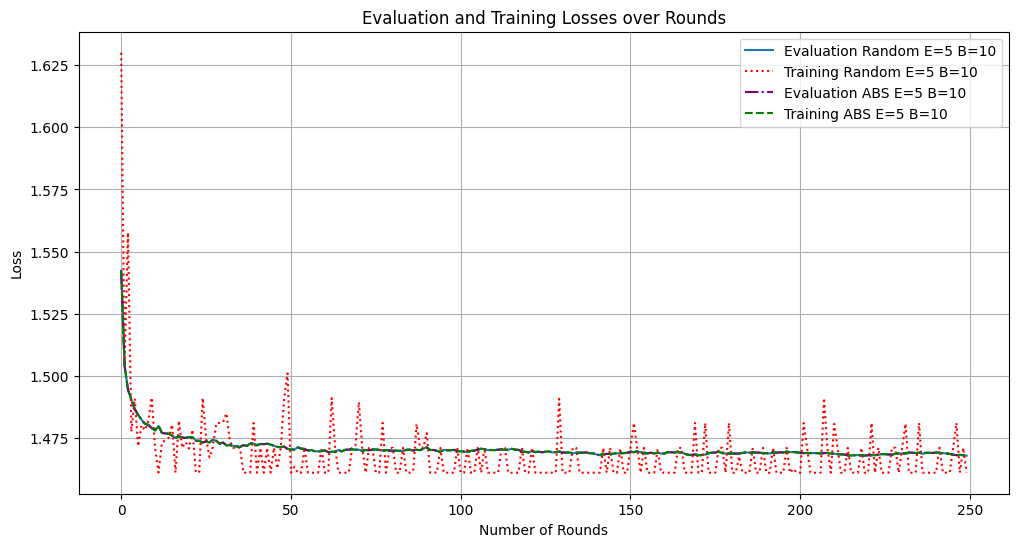

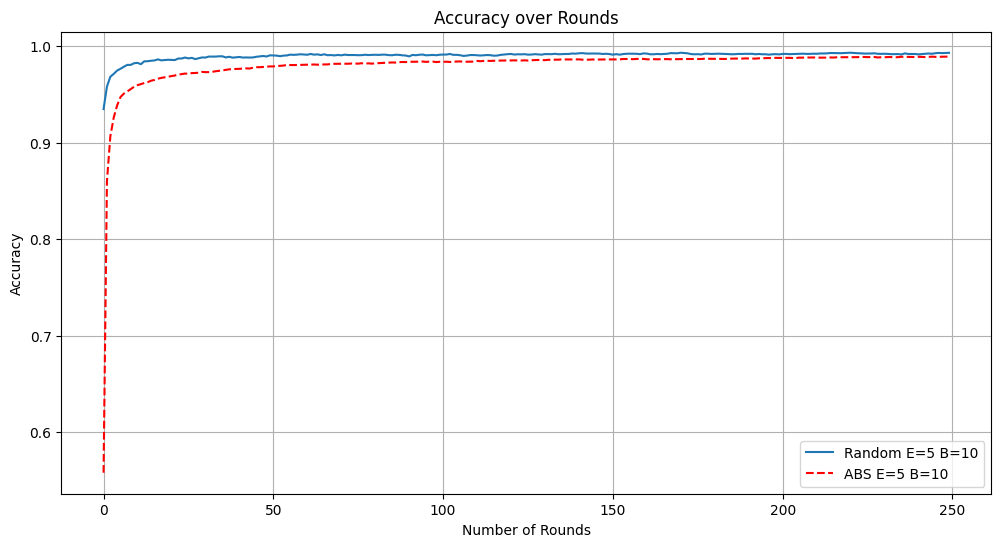

In [7]:
num_clients = 100 #Number of total clients
num_selected = 10 #Selection of clients
num_rounds = 250   # Number of rounds t
epochs = 5           #E epochs
batch_size = 10  # B mini batches

# Creating decentralized datasets

traindata = datasets.MNIST('./data', train=True, download=True, transform=transform)

traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transform
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers

global_model = CNN().to(device)
client_models = [CNN().to(device) for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.215) for model in client_models]

# Runnining FL
IID_accuracy_list = []
IID_avg_training_losses = []
IID_eval_losses = []
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    # client update
    loss = 0
    # Go through the selected clients
    for i in range(num_selected):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epochs=epochs)  
    # serer aggregate
    server_average(global_model, client_models)
    test_loss, acc = test(global_model, test_loader)
    IID_accuracy_list.append(acc)
    IID_eval_losses.append(test_loss)
    avg_training_loss = loss/ num_selected
    IID_avg_training_losses.append(avg_training_loss)
    if(r % 10 == 0):
        print('%d-th round' % r)
        print('average train loss %0.3g | test loss %0.3g | test acc: %0.5f' % (avg_training_loss, test_loss, acc))
        
torch.save(global_model,'IID_Model')
IID_MODEL = torch.load('IID_Model')

import numpy as np

num_clients = 100  # Number of total clients
num_selected = 10  # Selection of clients
num_rounds = 250  # Number of rounds
epochs = 5  # Epochs
batch_size = 10  # Mini-batches

# Create decentralized datasets
traindata = datasets.MNIST('./data', train=True, download=True, transform=transform)
#Splitting the data evenly choosing random indices
traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transform), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers
global_model = CNN().to(device)
client_models = [CNN().to(device) for _ in range(num_clients)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.215) for model in client_models]

# Track the age of each client (number of rounds since last selection)
client_age = np.zeros(num_clients)

# Running FL
IID_aged_accuracy_list = []
IID_aged_avg_training_losses = []
IID_aged_eval_losses = []

for r in range(num_rounds):
    # Calculate probabilities based on client age
    total_age = np.sum(client_age)
    probabilities = client_age / total_age if total_age > 0 else np.ones(num_clients) / num_clients
    
    # Select clients based on probabilities
    client_idx = np.random.choice(num_clients, size=num_selected, replace=False, p=probabilities)
    # Update client age
    client_age += 1
    client_age[client_idx] = 0  # Reset age for selected clients
    # Client update
    loss = 0
    for i in range(num_selected):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epochs=epochs)
    
    # Server aggregate
    server_average(global_model, client_models)
    
    # Evaluate global model
    test_loss, acc = test(global_model, test_loader)
    IID_aged_accuracy_list.append(acc)
    IID_aged_eval_losses.append(test_loss)
    avg_training_loss = loss / num_selected
    IID_aged_avg_training_losses.append(avg_training_loss)
    if(r % 10 == 0):
        print('%d-th round' % r)
        print('average train loss %0.3g | test loss %0.3g | test acc: %0.5f' % (avg_training_loss, test_loss, acc))

# Save the global model
torch.save(global_model, 'IID_Aged_Model')
IID_Aged_MODEL = torch.load('IID_Aged_Model')
IID_Aged_SUMMARY= summary(IID_Aged_MODEL, (1, 28, 28),verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
import matplotlib.pyplot as plt

# Plotting training and evaluation losses
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_eval_losses, label='Evaluation Random E=5 B=10')
plt.plot(range(num_rounds), IID_avg_training_losses, label='Training Random E=5 B=10', color='red',linestyle='dotted')
plt.plot(range(num_rounds), IID_eval_losses, label='Evaluation ABS E=5 B=10', color='purple', linestyle='dashdot')
plt.plot(range(num_rounds), IID_eval_losses, label='Training ABS E=5 B=10', color='green', linestyle='dashed')
plt.xlabel('Number of Rounds')
plt.ylabel('Loss')
plt.title('Evaluation and Training Losses over Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_accuracy_list, label='Random E=5 B=10')
plt.plot(range(num_rounds), IID_aged_accuracy_list, label='ABS E=5 B=10', color='red',linestyle='dashed')
plt.xlabel('Number of Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds')
plt.legend()
plt.grid(True)
plt.show()

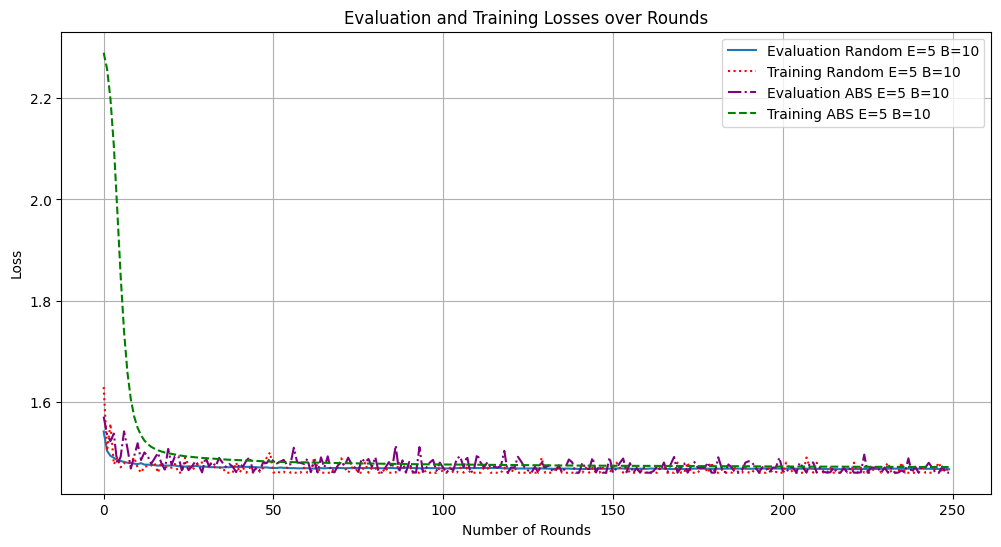

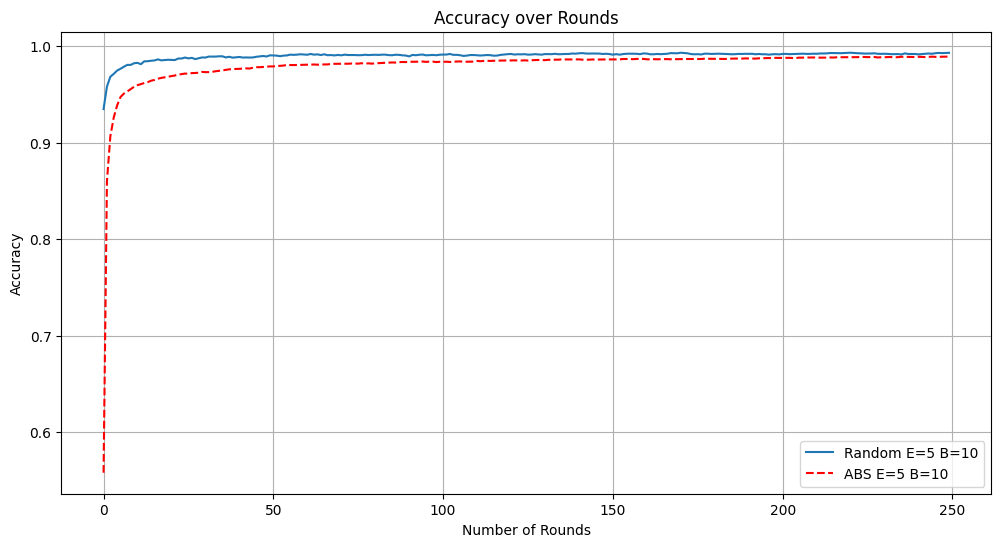

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_eval_losses, label='Evaluation Random E=5 B=10')
plt.plot(range(num_rounds), IID_avg_training_losses, label='Training Random E=5 B=10', color='red',linestyle='dotted')
plt.plot(range(num_rounds), IID_aged_avg_training_losses, label='Evaluation ABS E=5 B=10', color='purple', linestyle='dashdot')
plt.plot(range(num_rounds), IID_aged_eval_losses, label='Training ABS E=5 B=10', color='green', linestyle='dashed')
plt.xlabel('Number of Rounds')
plt.ylabel('Loss')
plt.title('Evaluation and Training Losses over Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_accuracy_list, label='Random E=5 B=10')
plt.plot(range(num_rounds), IID_aged_accuracy_list, label='ABS E=5 B=10', color='red',linestyle='dashed')
plt.xlabel('Number of Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds')
plt.legend()
plt.grid(True)
plt.show()

## Non IID Age Based Scheduling v random Scheduling

0-th round
average train loss 1.47 | test loss 2.24 | test acc: 0.186
10-th round
average train loss 1.47 | test loss 1.71 | test acc: 0.775
20-th round
average train loss 1.46 | test loss 1.65 | test acc: 0.837
30-th round
average train loss 1.46 | test loss 1.57 | test acc: 0.910
40-th round
average train loss 1.47 | test loss 1.57 | test acc: 0.907
50-th round
average train loss 1.46 | test loss 1.56 | test acc: 0.913
60-th round
average train loss 1.46 | test loss 1.54 | test acc: 0.930
70-th round
average train loss 1.46 | test loss 1.52 | test acc: 0.957
80-th round
average train loss 1.46 | test loss 1.51 | test acc: 0.961
90-th round
average train loss 1.46 | test loss 1.52 | test acc: 0.951
100-th round
average train loss 1.46 | test loss 1.51 | test acc: 0.956
110-th round
average train loss 1.46 | test loss 1.56 | test acc: 0.914
120-th round
average train loss 1.46 | test loss 1.53 | test acc: 0.934
130-th round
average train loss 1.46 | test loss 1.5 | test acc: 0.967
140-

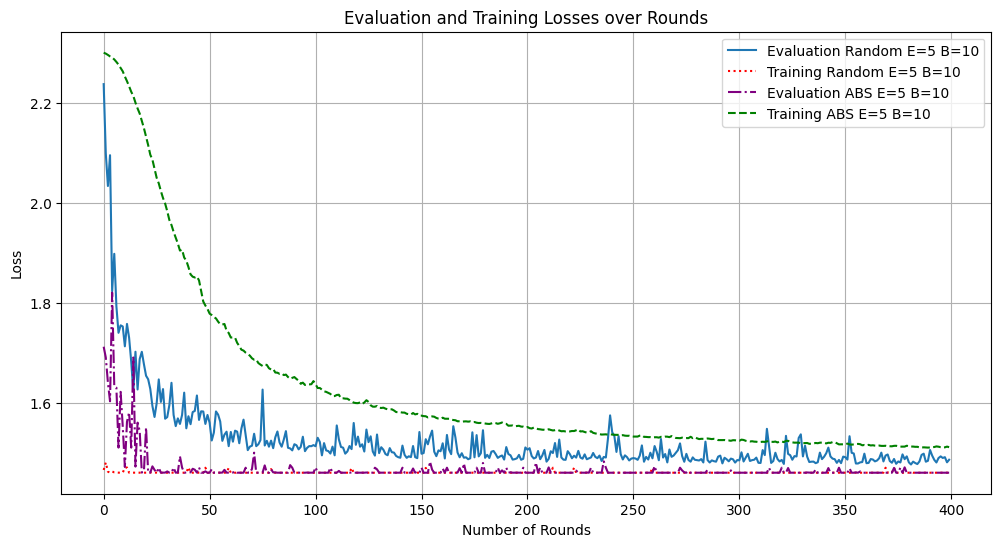

ValueError: x and y must have same first dimension, but have shapes (400,) and (250,)

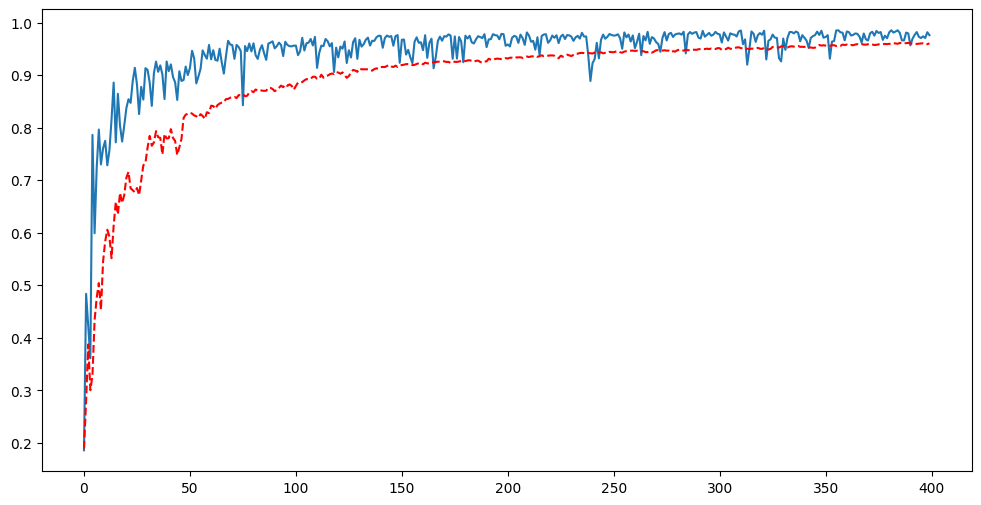

In [17]:
# NON-IID case: every client has images of two categories chosen from [0, 1], [2, 3], [4, 5], [6, 7], or [8, 9].

# Hyperparameters

num_clients = 100
num_selected = 10
num_rounds = 400
epochs = 5
batch_size = 10

# Creating decentralized datasets

traindata = datasets.MNIST('./data', train=True, download=True, transform=transform)
target_labels = torch.stack([traindata.targets == i for i in range(10)])
target_labels_split = []
for i in range(5):
    target_labels_split += torch.split(torch.where(target_labels[(2 * i):(2 * (i + 1))].sum(0))[0], int(60000 / num_clients))
    
traindata_split = [torch.utils.data.Subset(traindata, tl) for tl in target_labels_split]
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transform), batch_size=batch_size, shuffle=True)


# Instantiate models and optimizers

global_model = CNN().to(device)
client_models = [CNN().to(device) for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

# Runnining FL
nonIID_accuracy_list = []
nonIID_avg_training_losses = []
nonIID_eval_losses = []
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]

    # client update
    loss = 0
    for i in range(num_selected):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epochs=epochs)
    
    # serer aggregate
    server_average(global_model, client_models)
    test_loss, acc = test(global_model, test_loader)
    nonIID_accuracy_list.append(acc)
    nonIID_eval_losses.append(test_loss)
    avg_training_loss = loss/ num_selected
    nonIID_avg_training_losses.append(avg_training_loss)
    if(r % 10 == 0):
        print('%d-th round' % r)
        print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))


import numpy as np

# num_clients = 100  # Number of total clients
# num_selected = 10  # Selection of clients
# num_rounds = 1  # Number of rounds
# epochs = 2  # Epochs
# batch_size = 10  # Mini-batches

# Creating decentralized datasets

traindata = datasets.MNIST('./data', train=True, download=True, transform=transform)
target_labels = torch.stack([traindata.targets == i for i in range(10)])
target_labels_split = []

# Range 5 because there are 5 set of shards
for i in range(5):
    target_labels_split += torch.split(torch.where(target_labels[(2 * i):(2 * (i + 1))].sum(0))[0], int(60000 / num_clients))
    
traindata_split = [torch.utils.data.Subset(traindata, tl) for tl in target_labels_split]
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transform), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers
global_model = CNN().to(device)
client_models = [CNN().to(device) for _ in range(num_clients)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.215) for model in client_models]

# Track the age of each client (number of rounds since last selection)
client_age = np.zeros(num_clients)

# Running FL
nonIID_aged_accuracy_list = []
nonIID_aged_avg_training_losses = []
nonIID_aged_eval_losses = []

for r in range(num_rounds):
    # Calculate probabilities based on client age
    total_age = np.sum(client_age)
    probabilities = client_age / total_age if total_age > 0 else np.ones(num_clients) / num_clients
    
    # Select clients based on probabilities
    client_idx = np.random.choice(num_clients, size=num_selected, replace=False, p=probabilities)
    # Update client age
    client_age += 1
    client_age[client_idx] = 0  # Reset age for selected clients
    # Client update
    loss = 0
    for i in range(num_selected):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epochs=epochs)
    
    # Server aggregate
    server_average(global_model, client_models)
    
    # Evaluate global model
    test_loss, acc = test(global_model, test_loader)
    nonIID_aged_accuracy_list.append(acc)
    nonIID_aged_eval_losses.append(test_loss)
    avg_training_loss = loss / num_selected
    nonIID_aged_avg_training_losses.append(avg_training_loss)
    if(r % 10 == 0):
        print('%d-th round' % r)
        print('average train loss %0.3g | test loss %0.3g | test acc: %0.5f' % (avg_training_loss, test_loss, acc))

plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), nonIID_eval_losses, label='Evaluation Random E=5 B=10')
plt.plot(range(num_rounds), nonIID_avg_training_losses, label='Training Random E=5 B=10', color='red',linestyle='dotted')
plt.plot(range(num_rounds), nonIID_aged_avg_training_losses, label='Evaluation ABS E=5 B=10', color='purple', linestyle='dashdot')
plt.plot(range(num_rounds), nonIID_aged_eval_losses, label='Training ABS E=5 B=10', color='green', linestyle='dashed')
plt.xlabel('Number of Rounds')
plt.ylabel('Loss')
plt.title('Evaluation and Training Losses over Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), nonIID_accuracy_list, label='Random E=5 B=10')
plt.plot(range(num_rounds), nonIID_aged_accuracy_list, label='ABS E=5 B=10', color='red',linestyle='dashed')
plt.plot(range(num_rounds), IID_accuracy_list[:250], label='Random E=5 B=10')
plt.plot(range(num_rounds), IID_aged_accuracy_list[:250], label='ABS E=5 B=10', color='orange',linestyle='dashed')
plt.xlabel('Number of Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds')
plt.legend()
plt.grid(True)
plt.show()

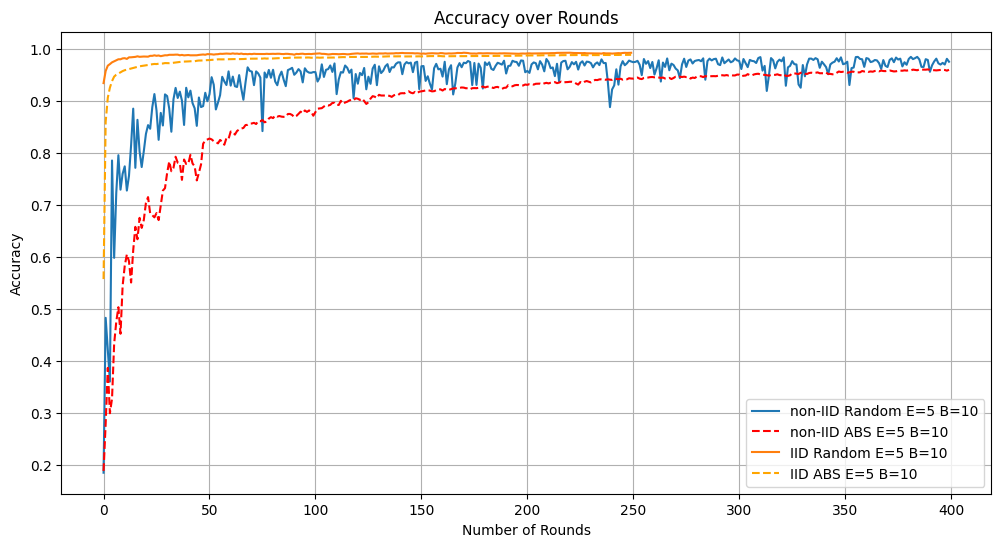

In [20]:
# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), nonIID_accuracy_list, label='non-IID Random E=5 B=10')
plt.plot(range(num_rounds), nonIID_aged_accuracy_list, label='non-IID ABS E=5 B=10', color='red',linestyle='dashed')
plt.plot(range(num_rounds-150), IID_accuracy_list, label='IID Random E=5 B=10')
plt.plot(range(num_rounds-150), IID_aged_accuracy_list, label='IID ABS E=5 B=10', color='orange',linestyle='dashed')
plt.xlabel('Number of Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds')
plt.legend()
plt.grid(True)
plt.show()